# Schema Usage

The schema does not actually store any data.  Instead, it is an interface which allows us to interact with numpy/torch tensors in a semantic manner.  It lets us convert between storage vectors (i.e. how we store the building parameters numerically on disk), simulation objects (e.g. Archetypal Templates and PyUmi Shoeboxes) and machine learning model imports (i.e. torch tensors with full hourly schedule data).

## Notebook setup

We need some jank to get relative imports working.

In [125]:
import os
import sys
from nrel_uitls import CLIMATEZONES, RESTYPES
import json
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [126]:
import matplotlib.pyplot as plt
import numpy as np

## Initialize the Schema

In [127]:
from schema import Schema, ShoeboxGeometryParameter, BuildingTemplateParameter, WhiteboxSimulation, WindowParameter, SchedulesParameters
schema = Schema()

Let's see what's in the schema:

In [4]:
schema.parameter_names

['batch_id',
 'variation_id',
 'program_type',
 'vintage',
 'climate_zone',
 'base_epw',
 'width',
 'height',
 'facade_2_footprint',
 'perim_2_footprint',
 'roof_2_footprint',
 'footprint_2_ground',
 'wwr',
 'orientation',
 'HeatingSetpoint',
 'CoolingSetpoint',
 'LightingPowerDensity',
 'EquipmentPowerDensity',
 'PeopleDensity',
 'Infiltration',
 'FacadeMass',
 'RoofMass',
 'FacadeRValue',
 'RoofRValue',
 'SlabRValue',
 'WindowSettings',
 'schedules_seed',
 'schedules']

We can access a schema parameter from the schema with list indexing:

In [5]:
print(schema["width"])
print(schema["schedules"])
print(schema["orientation"])

---width---
shape_storage=(1,), shape_ml=(1,), dtype=scalar
Width [m]
---schedules---
shape_storage=(3, 21), shape_ml=(3, 8760), dtype=matrix
A matrix in the storage vector with operations to apply to schedules; a matrix of timeseries in ml vector
---orientation---
shape_storage=(1,), shape_ml=(4,), dtype=onehot
Shoebox Orientation


We see that each parameter may have multiple different lengths in the storage vector and ML vector.

We can also print a summary of the whole schema:

In [6]:
print(schema)

-------- Schema --------
---- batch_id ----
shape storage: (1,) / shape ml: (0,)
location storage: 0->1 / location ml: 0->0

---- variation_id ----
shape storage: (1,) / shape ml: (0,)
location storage: 1->2 / location ml: 0->0

---- program_type ----
shape storage: (1,) / shape ml: (19,)
location storage: 2->3 / location ml: 0->19

---- vintage ----
shape storage: (1,) / shape ml: (1,)
location storage: 3->4 / location ml: 19->20

---- climate_zone ----
shape storage: (1,) / shape ml: (15,)
location storage: 4->5 / location ml: 20->35

---- base_epw ----
shape storage: (1,) / shape ml: (0,)
location storage: 5->6 / location ml: 35->35

---- width ----
shape storage: (1,) / shape ml: (1,)
location storage: 6->7 / location ml: 35->36

---- height ----
shape storage: (1,) / shape ml: (1,)
location storage: 7->8 / location ml: 36->37

---- facade_2_footprint ----
shape storage: (1,) / shape ml: (1,)
location storage: 8->9 / location ml: 37->38

---- perim_2_footprint ----
shape storage: (

We see that the length of the storage vector is significantly smaller than the length the vector the ML model will see.

## Generating new design vectors in storage space

First let's generate a new, empty design vector, and update the Roof R-Value, and then check that it updated correctly:

In [7]:
storage_vector = schema.generate_empty_storage_vector()
schema.update_storage_vector(storage_vector=storage_vector, parameter="RoofRValue", value=2.5)
schema["RoofRValue"].extract_storage_values(storage_vector)

2.5

If we print out the full vector, we should be able to see the 2.5 and a whole bunch of zeros (and a few 1s in the schedules indicated to use the original schedules):

In [8]:
print(storage_vector)

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  2.5 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]


Let's create a new batch of designs:

In [9]:
batch_size = 20
storage_batch = schema.generate_empty_storage_batch(batch_size)
storage_batch.shape

(20, 92)

Great, we see that it has 20 design vectors with 90 values each.

Let's try updating all of the facade R-values values in a batch with the same value:

In [10]:
schema.update_storage_batch(storage_batch, parameter="FacadeRValue", value=1.2)
schema["FacadeRValue"].extract_storage_values_batch(storage_batch)

array([[1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2],
       [1.2]])

Now let's try updating an entire batch with random values.  We can also unnormalize the uniform random variable into the desired range:

In [11]:
parameter = "SlabRValue"
n = batch_size
shape = (n, *schema[parameter].shape_storage)
values = np.random.rand(*shape) # create a random sample with appropriate shape
values = schema[parameter].unnormalize(values) # schema parameter must be a numeric type with min/max defined for unnormalize to work
schema.update_storage_batch(storage_batch, parameter=parameter, value=values)
schema[parameter].extract_storage_values_batch(storage_batch)

array([[ 2.59525875],
       [12.65522719],
       [ 3.70047635],
       [ 5.6916405 ],
       [ 4.35157665],
       [ 9.01523492],
       [13.86711597],
       [ 1.75737402],
       [ 5.88120932],
       [ 4.46383538],
       [ 3.07739509],
       [ 7.85438755],
       [ 7.7517642 ],
       [11.89398527],
       [ 7.43719945],
       [ 7.84546615],
       [ 4.78919141],
       [14.09541587],
       [ 1.14774239],
       [10.60207537]])

Finally, let's try updating just a subset of the batch by using the `index` parameter:

*nb: we can also use an int instead of a tuple for `index` to only update a single vector's parameter*

In [12]:
start = 2
n = 8
end = start + n
parameter = "FacadeRValue"
shape = (n, *schema[parameter].shape_storage)
values = np.random.rand(*shape) # create a random sample with appropriate shape

schema.update_storage_batch(storage_batch, index=(start,end), parameter=parameter, value=values)
schema[parameter].extract_storage_values_batch(storage_batch) 

array([[1.2       ],
       [1.2       ],
       [0.3       ],
       [0.3       ],
       [0.3       ],
       [0.33200118],
       [0.4421391 ],
       [0.35517817],
       [0.3       ],
       [0.3       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ],
       [1.2       ]])

A useful technique will be to start with a small batch, and then duplicate it in concatenations along `axis=0` as we build up our mixed grid/hypercube/random samples.  Let's start by creating a new batch with a single vector.

In [13]:
storage_batch = schema.generate_empty_storage_batch(1)
storage_batch.shape

(1, 92)

Now let's say some baseline parameters (e.g. pulled from ResStock)

In [14]:
#TODO

with open("./data/city_map.json","r") as f:
	city_map = json.load(f)

schema.update_storage_batch(storage_batch, parameter="FacadeRValue", value=2.3)
schema.update_storage_batch(storage_batch, parameter="RoofRValue", value=3.1)
schema.update_storage_batch(storage_batch, parameter="LightingPowerDensity", value=7.2)
schema.update_storage_batch(storage_batch, parameter="program_type", value=RESTYPES["Multi-Family with 5+ Units"])
schema.update_storage_batch(storage_batch, parameter="vintage", value=1920)
schema.update_storage_batch(storage_batch, parameter="climate_zone", value=CLIMATEZONES["5A"])
schema.update_storage_batch(storage_batch, parameter="base_epw", value=city_map["FL, Lehigh Acres"]["idx"])
storage_batch = np.concatenate([storage_batch for _ in range(4)], axis=0)
storage_batch

array([[0.00e+00, 0.00e+00, 3.00e+00, 1.92e+03, 1.20e+01, 2.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 7.20e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.30e+00, 3.10e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

Now let's set the orientations:

In [15]:
values = np.arange(4).reshape(-1,1)
parameter = "orientation"
schema.update_storage_batch(storage_batch, parameter=parameter, value=values)
schema[parameter].extract_storage_values_batch(storage_batch)

array([[0.],
       [1.],
       [2.],
       [3.]])

Looks good!  Now let's stack this up and begin generating some geometric variations.

In [16]:
orientations_per_base = 4
geometric_variations_per_orientation = 5

In [17]:
storage_batch = np.repeat(storage_batch, geometric_variations_per_orientation, axis=0)
storage_batch.shape

(20, 92)

In [18]:
schema["orientation"].extract_storage_values_batch(storage_batch)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

Looks good!  let's start populating this: if we wanted to use repeating values, we could do nested loops:

In [19]:
n = geometric_variations_per_orientation # how many design vectors in this mini batch
for i in range(orientations_per_base):
	start = i*n # where this mini batch starts in the parent batch
	end = start + n # where this mini batch ends in the parent batch
	for j,parameter in enumerate(schema.parameters):
		if isinstance(parameter, ShoeboxGeometryParameter):
			name = parameter.name
			mean = parameter.mean
			std = parameter.std
			shape = parameter.shape_storage
			np.random.seed(j+20923) # arbitrary but reliable seed
			values = np.random.normal(loc=mean, scale=std, size=(n, *shape))
			# values = parameter.unnormalize(values)
			schema.update_storage_batch(storage_batch, index=(start,end), parameter=name, value=values)


In [20]:
schema["wwr"].extract_storage_values_batch(storage_batch)

array([[0.66341135],
       [0.21420996],
       [0.28046024],
       [0.43220432],
       [0.27125807],
       [0.66341135],
       [0.21420996],
       [0.28046024],
       [0.43220432],
       [0.27125807],
       [0.66341135],
       [0.21420996],
       [0.28046024],
       [0.43220432],
       [0.27125807],
       [0.66341135],
       [0.21420996],
       [0.28046024],
       [0.43220432],
       [0.27125807]])

In [21]:
schema["width"].extract_storage_values_batch(storage_batch)

array([[4.53980835],
       [7.08775209],
       [5.68124462],
       [5.36848356],
       [4.65878866],
       [4.53980835],
       [7.08775209],
       [5.68124462],
       [5.36848356],
       [4.65878866],
       [4.53980835],
       [7.08775209],
       [5.68124462],
       [5.36848356],
       [4.65878866],
       [4.53980835],
       [7.08775209],
       [5.68124462],
       [5.36848356],
       [4.65878866]])

Great, these are repeating correctly!  Now, suppose we want to just slightly perturb all of these so that they aren't perfectly repeating, but are close to repeating:

In [22]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
	if isinstance(parameter, ShoeboxGeometryParameter):
		name = parameter.name
		shape = parameter.shape_storage
		perturbations = np.random.rand(n,*shape)*0.2 - 0.1
		values = parameter.extract_storage_values_batch(storage_batch)
		values += perturbations
		schema.update_storage_batch(storage_batch,parameter=name,value=values)

schema["width"].extract_storage_values_batch(storage_batch)

array([[4.46561945],
       [7.15050351],
       [5.58278163],
       [5.30600348],
       [4.74848788],
       [4.59392754],
       [7.15981132],
       [5.5983878 ],
       [5.37464032],
       [4.612936  ],
       [4.6360343 ],
       [6.99854612],
       [5.61550081],
       [5.27512586],
       [4.73889535],
       [4.46874368],
       [7.03901284],
       [5.59775437],
       [5.33183035],
       [4.71285051]])

Great!  We see that they are close to their previous values, but not identical.  

Alternatively, we might prefer to simply use fully random geometric variations for all of our orientation duplicates, rather than repeating the geometry across orientations:

In [23]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
	if isinstance(parameter, ShoeboxGeometryParameter):
		name = parameter.name
		shape = parameter.shape_storage
		values = np.random.rand(n,*shape)
		values = parameter.unnormalize(values)
		schema.update_storage_batch(storage_batch,parameter=name,value=values)

schema["width"].extract_storage_values_batch(storage_batch)
schema["wwr"].extract_storage_values_batch(storage_batch)

array([[0.69888121],
       [0.77782901],
       [0.12920131],
       [0.87097066],
       [0.58186329],
       [0.18219204],
       [0.28133598],
       [0.85173211],
       [0.24349067],
       [0.59616163],
       [0.53733236],
       [0.6186395 ],
       [0.71609532],
       [0.06554596],
       [0.82341664],
       [0.59090685],
       [0.40197341],
       [0.60589851],
       [0.54136851],
       [0.05026016]])

Or, if a normal distribution is desired, we can do that as well:

In [24]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
    if isinstance(parameter, ShoeboxGeometryParameter):
        name = parameter.name
        mean = parameter.mean
        std = parameter.std
        shape = parameter.shape_storage
        values = np.random.normal(loc=mean, scale=std, size=(n,*shape))
        schema.update_storage_batch(storage_batch,parameter=name,value=values)

schema["width"].extract_storage_values_batch(storage_batch)
schema["wwr"].extract_storage_values_batch(storage_batch)

array([[0.18531549],
       [0.84086447],
       [0.34846326],
       [0.83451545],
       [0.83144303],
       [0.19098249],
       [0.46053439],
       [0.05      ],
       [0.78023185],
       [0.40915207],
       [0.23058299],
       [0.26778203],
       [0.34534503],
       [0.05      ],
       [0.05      ],
       [0.12696672],
       [0.37375216],
       [0.83530432],
       [0.16105618],
       [0.47976358]])

Later on in this file, we will be inspecting template parameters as well, so let's just arbitrarily set some building template parameters for each design:

In [25]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
	if isinstance(parameter, (BuildingTemplateParameter, WindowParameter)):
		name = parameter.name
		mean = parameter.mean
		std = parameter.std
		shape = parameter.shape_storage
		values = np.random.normal(loc=mean, scale=std, size=(n,*shape))
		schema.update_storage_batch(storage_batch,parameter=name,value=values)

print("LPD:")
print(schema["LightingPowerDensity"].extract_storage_values_batch(storage_batch)[:3])
print("Window Settings:")
print(schema["WindowSettings"].extract_storage_values_batch(storage_batch)[:3])

LPD:
[[17.05708042]
 [ 0.64775771]
 [15.71234346]]
Window Settings:
[[4.48048788 0.26943049 0.58511694]
 [7.         0.51141507 0.68205774]
 [3.53998978 0.25247972 0.52948567]]


We need to make sure we don't create any bad heating/cooling setpoint combos!

In [26]:
heating_setpoints = schema["HeatingSetpoint"].extract_storage_values_batch(storage_batch)
cooling_setpoints = schema["CoolingSetpoint"].extract_storage_values_batch(storage_batch)
heating_setpoints = np.where(heating_setpoints > cooling_setpoints, cooling_setpoints-2, heating_setpoints)
schema.update_storage_batch(storage_batch, parameter="HeatingSetpoint", value=heating_setpoints)

Suppose this was our finished batch.  We can save it to an HDF5 file.  Let's say this was building 23 from our ResStock database.

In [27]:
import h5py
from storage import upload_to_bucket

In [28]:
# Update the building IDs
batch_id = 23 # suppose this is the base building we are drawing from
n = storage_batch.shape[0]
variation_ids = np.arange(n)
schema.update_storage_batch(storage_batch,parameter="batch_id",value=batch_id)
schema.update_storage_batch(storage_batch,parameter="variation_id",value=variation_ids)

# Write to an HDF5 file
slug = f"batch_{batch_id:05d}.hdf5"
outfile = f"./data/hdf5/{slug}"
with h5py.File(outfile,"w") as f:
    f.create_dataset(name="storage_vectors", shape=storage_batch.shape, dtype=storage_batch.dtype, data=storage_batch)

# upload to cloud bucket for easy backup
destination = f"demo-batch-data/{slug}"
upload_to_bucket(destination, outfile)


INFO:Storage:Uploading ./data/hdf5/batch_00023.hdf5 to bucket:demo-batch-data/batch_00023.hdf5...
INFO:Storage:Done uploading.


## Simulation

Now let's suppose you want to simulate a design vector.  Let's open up an HDF5 file and read in only the first storage vector to get started.

In [29]:
batch_id = 23
slug = f"batch_{batch_id:05d}.hdf5"
outfile = f"./data/hdf5/{slug}"
storage_vector = None
with h5py.File(outfile,'r') as f:
    storage_vector = f["storage_vectors"][0]

schema["batch_id"].extract_storage_values(storage_vector), schema["variation_id"].extract_storage_values(storage_vector)

(23.0, 0.0)

Great! Looks like we successfully opened the 0th design variation from batch 23.

Now let's create a simulation object for this storage vector:

In [30]:
%%time

with h5py.File(outfile,'r') as f:
    storage_vector = f["storage_vectors"][0]
# just using 
# TODO: orientation
# TODO: setpoint value overlaps
# TODO: Fix template Selector
# TODO: window u value coming out different
schema.update_storage_vector(storage_vector, parameter="climate_zone", value=CLIMATEZONES["2A"])
schema.update_storage_vector(storage_vector, parameter="vintage", value=1920)
schema.update_storage_vector(storage_vector, parameter="program_type", value=RESTYPES["Multi-Family with 5+ Units"])
schema.update_storage_vector(storage_vector, parameter="base_epw", value=city_map["CA, Los Angeles"]["idx"])
schema.update_storage_vector(storage_vector, "height", 3)
schema.update_storage_vector(storage_vector, "width", 3)
schema.update_storage_vector(storage_vector, "facade_2_footprint", 0.3)
schema.update_storage_vector(storage_vector, "perim_2_footprint", 0.5)
schema.update_storage_vector(storage_vector, "roof_2_footprint", 0.05)
schema.update_storage_vector(storage_vector, "footprint_2_ground", 0.5)
schema.update_storage_vector(storage_vector, "wwr", 0.3)
schema.update_storage_vector(storage_vector, "orientation", 0)
schema.update_storage_vector(storage_vector, "Infiltration", 1.0)
schema.update_storage_vector(storage_vector, "HeatingSetpoint", 18)
schema.update_storage_vector(storage_vector, "CoolingSetpoint", 24)
schema.update_storage_vector(storage_vector, "PeopleDensity", 0.05)
schema.update_storage_vector(storage_vector, "LightingPowerDensity", 3)
schema.update_storage_vector(storage_vector, "EquipmentPowerDensity", 7)
schema.update_storage_vector(storage_vector, "RoofRValue", 2)
schema.update_storage_vector(storage_vector, "SlabRValue", 2)
schema.update_storage_vector(storage_vector, "FacadeRValue", 2)
schema.update_storage_vector(storage_vector, "FacadeMass", 10000) 
schema.update_storage_vector(storage_vector, "RoofMass", 10000)
schema.update_storage_vector(storage_vector, "WindowSettings", np.array([1.0,0.5,0.5])) 

schedules = schema["schedules"].extract_storage_values(storage_vector)
sched_demo = "NONE"
if sched_demo == "BASELINE":
    # Equipment
    # pass
    # Occupancy
    schedules[1, SchedulesParameters.op_indices["noise"]] = 0.2
    # Lights
    schedules[2, SchedulesParameters.op_indices["invert"]] = 1
elif sched_demo == "SINE":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["sin_overwrite"]] = 1
    schedules[0, SchedulesParameters.op_indices["sin_0_amp"]] = 0.5
    schedules[0, SchedulesParameters.op_indices["sin_0_freq"]] = 365
    # Occupancy
    schedules[1, SchedulesParameters.op_indices["sin_overwrite"]] = 1
    schedules[1, SchedulesParameters.op_indices["sin_0_amp"]] = 0.5
    schedules[1, SchedulesParameters.op_indices["sin_0_freq"]] = 365
    schedules[1, SchedulesParameters.op_indices["sin_1_amp"]] = 0.5
    schedules[1, SchedulesParameters.op_indices["sin_1_freq"]] = 4
    # Lights
    schedules[2, SchedulesParameters.op_indices["sin_overwrite"]] = 1
    schedules[2, SchedulesParameters.op_indices["sin_0_amp"]] = 1.0
    schedules[2, SchedulesParameters.op_indices["sin_0_freq"]] = 24 # 2 per mo
elif sched_demo == "BERNOULLI":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[0, SchedulesParameters.op_indices["uniform_random_samples"]] = 10 # samples per pattern
    schedules[0, SchedulesParameters.op_indices["uniform_random_mode"]] = 1 # bernoulli
    # Occupancy
    schedules[1, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[1, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # samples per pattern
    schedules[1, SchedulesParameters.op_indices["uniform_random_mode"]] = 1 # bernoulli
    # Lights
    schedules[2, SchedulesParameters.op_indices["uniform_random_dilation"]] = 24 # hours per sample
    schedules[2, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # samples per pattern
    schedules[2, SchedulesParameters.op_indices["uniform_random_mode"]] = 1 # bernoulli
elif sched_demo == "UNI_RAND":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[0, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # samples per pattern
    schedules[0, SchedulesParameters.op_indices["uniform_random_mode"]] = 0 # continuous

    # Occupancy
    schedules[1, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[1, SchedulesParameters.op_indices["uniform_random_samples"]] = 24 # samples per pattern
    schedules[1, SchedulesParameters.op_indices["uniform_random_mode"]] = 0 # continuous

    # Lights
    schedules[2, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # hours per sample
    schedules[2, SchedulesParameters.op_indices["uniform_random_samples"]] = 22 # samples per pattern
    schedules[2, SchedulesParameters.op_indices["uniform_random_mode"]] = 0 # continuous
elif sched_demo == "PULSE":
    # Equipment
    schedules[0, SchedulesParameters.op_indices["pulse_period"]] = 24*7 # 7 day cycle
    schedules[0, SchedulesParameters.op_indices["pulse_width"]] = 24*5 # on for 5 days

    # Occupancy
    schedules[1, SchedulesParameters.op_indices["pulse_period"]] = 24 # 1 day cycle
    schedules[1, SchedulesParameters.op_indices["pulse_width"]] = 15 # on for 5 days

    # Lights
    schedules[2, SchedulesParameters.op_indices["pulse_period"]] = 23 # 23 hr cycle
    schedules[2, SchedulesParameters.op_indices["pulse_width"]] = 18 # on for 11 hrs

# schedules[2, SchedulesParameters.op_indices["noise"]] = 0.5 # Occupancy
schedules[1, SchedulesParameters.op_indices["noise"]] = 0.3 # Lights
# schedules[0, SchedulesParameters.op_indices["noise"]] = 0.5 # equip

whitebox_sim = WhiteboxSimulation(schema, storage_vector)
whitebox_sim.summarize()

INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:Geometries rotated by 0 degrees around building centroid




------------------------------
EPW: c:\Users\Sam Wolk\Dropbox\mit\2023_spring\ml\ml-for-building-energy-modeling\ml-for-bem\data\epws\city_epws_indexed\cityidx_0000_USA_CA-Climate Zone 9.722880_CTZRV2.epw
Selected Template: PROG_03_VINTAGE_00_MASS_1
---ShoeboxConfig---
Height 3.0
Width 3.0
WWR 0.3
Facade2Foot 0.3
Perim2Foot 0.5
Foot2Gnd [adia %] 0.5
Roof2Gnd [adia %] 0.05
Orientation 0.0
---PERIM/CORE Values---
Heating Setpoint: 18.0 18.0
Cooling Setpoint: 24.0 24.0
Equipment Power Density: 7.0 7.0
Lighting Power Density: 3.0 3.0
People Density: 0.05 0.05
Infiltration: 1.0 1.0
Roof HeatCap: 12796.244999999999 12796.244999999999
Facade HeatCap: 12796.245 12796.245
U Window: 1.216762723917989
VLT 0.5
Roof RSI: 2.0
Facade RSI: 2.0
Slab RSI: 2.0
Partition RSI: 0.6526162790697675
Ground RSI: 2.0
Roof Assembly: [1881789521488:Fiberglass_Batts_roof with thickness of 0.082 m, 14:Gypsum_Board with thickness of 0.015 m]
Facade Assembly: [1881789521248:Fiberglass_Batts_facade with thickness of 

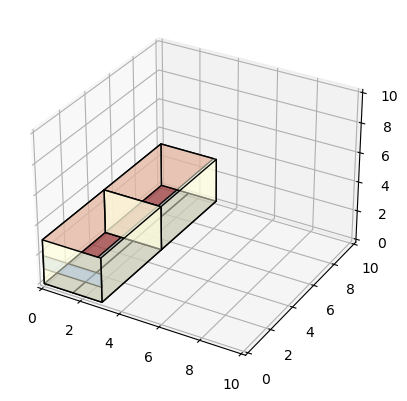

<Figure size 640x480 with 0 Axes>

INFO:archetypal:Showed the plot in 0.01 seconds


(<Figure size 640x480 with 0 Axes>, [])

In [31]:
whitebox_sim.shoebox.view_model()

0.Perimeter.Loads.EquipmentAvailabilitySchedule: mean daily min:0.19 mean:0.42 max:0.70 quantity 7.0

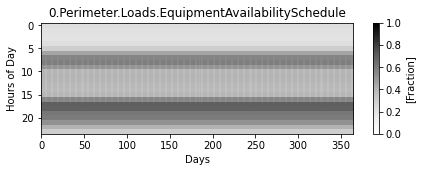

In [32]:
whitebox_sim.template.Perimeter.Loads.EquipmentAvailabilitySchedule

0.Perimeter.Loads.LightsAvailabilitySchedule: mean daily min:0.01 mean:0.41 max:0.97 quantity 3.0

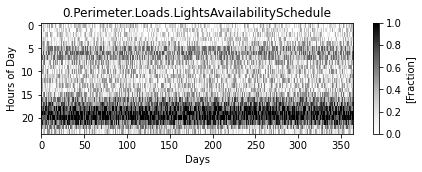

In [33]:
whitebox_sim.template.Perimeter.Loads.LightsAvailabilitySchedule

0.Perimeter.Loads.OccupancySchedule: mean daily min:0.25 mean:0.67 max:0.97 quantity 0.05

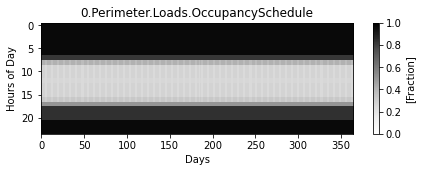

In [34]:
whitebox_sim.template.Perimeter.Loads.OccupancySchedule

Great!  Jeez I'm saying that a lot in this notebook.

Let's run an actual simulation.

In [35]:
%%capture
# capture hides output
res_hourly, res_monthly = whitebox_sim.simulate()

INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:ExpandObjects Started.
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf: Begin reading Energy+.idd file.
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf: Done reading Energy+.idd file.
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.062
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:ExpandObjects completed in 0.18 seconds
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:Simulation started
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:EnergyPlus Starting
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.05.14 22:32
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:Adjusting Air System Sizing
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:Initializing Simulation
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:Reporting Surfaces
INFO:ddc55854-f2e1-11ed-a87d-841b77d62e9a.idf:Beginning Primary Simu

Looks like it simulated successfully! Let's confirm by taking a look at the the tables.

In [36]:
print(whitebox_sim.hourly.values.sum()*whitebox_sim.JOULES_TO_KWH / whitebox_sim.shoebox.total_building_area)
whitebox_sim.totals
# (heating, cooling) , (h_norm, c_norm)

59.958237011795


((94.55718039347187, 1704.189929960378),
 (3.151906013115729, 56.80633099867927))

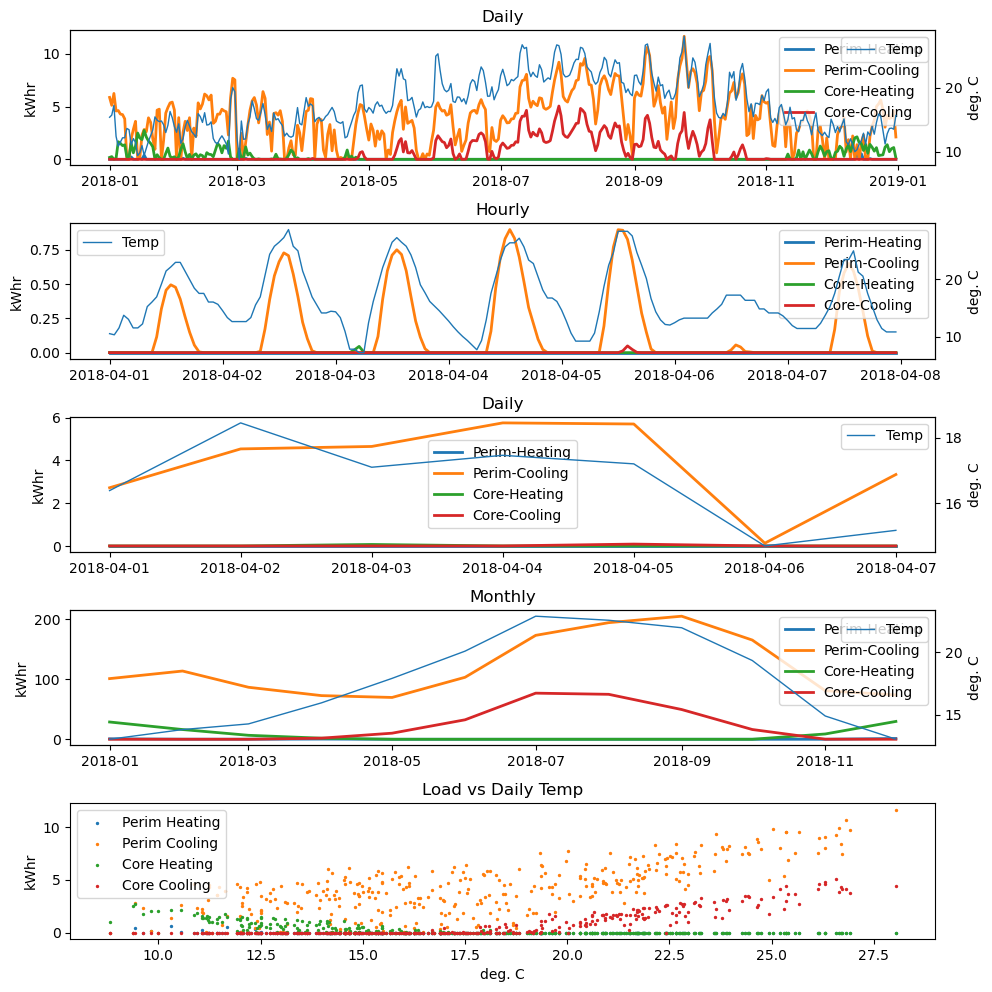

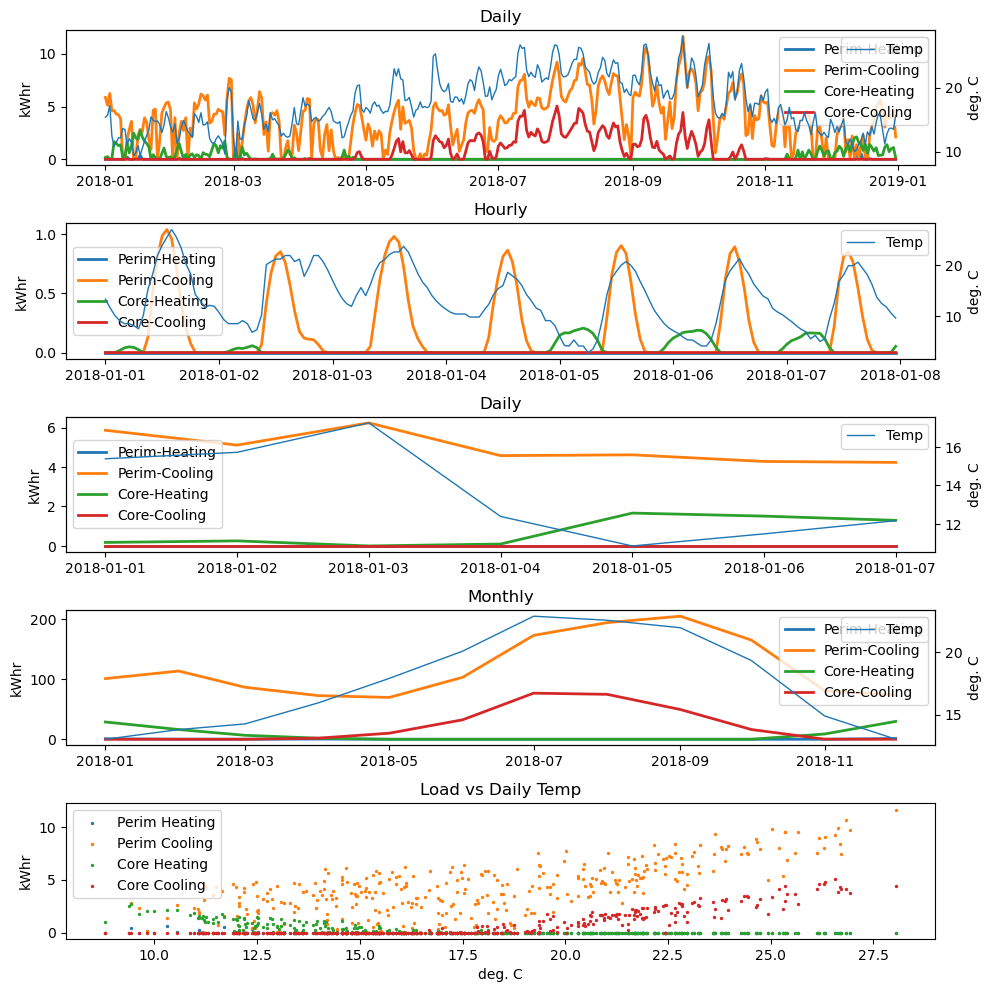

In [37]:
whitebox_sim.plot_results(start=24*30*3,length=7*24, normalize=False)
whitebox_sim.plot_results(start=0,length=7*24, normalize=False)

## Batch Simulation

Now let's take a look at simulating a whole batch.

First, we need to instantiate the batch simulator.  This configures an object which will automatically handle identifying and opening the correct storage vector batch, and can automatically run simulations in parallel and write results to a new HDF5 file.  It will also automatically upload the results files to the cloud bucket.

*nb: `simulate.py` can be called from the CLI in order to facilitate easily launching many Batches simultaneously from many processes running on multiple servers, i.e.* `python simulate.py <batch_id> <n of processes>`

In [128]:
from simulate import BatchSimulator
batch_runner = BatchSimulator(schema, batch_id=23, processes=5)

INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 23
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 23...


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'c:\Users\Sam Wolk\Dropbox\mit\2023_spring\ml\ml-for-building-energy-modeling\ml-for-bem\data\hdf5\batch_00023.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

To simulate, all we need to do is call the `run` method!

In [39]:
%%capture
batch_runner.run()

INFO:Batch Simulator:Launching parallel processing for BATCH:23 with 5 p.processors...
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILAT

Afterwards, we can automatically upload the results to the Google storage bucket:

In [40]:
batch_runner.upload()

INFO:Batch Simulator:Upload results to GCP bucket for BATCH:23...
INFO:Storage:Uploading c:\Users\Sam Wolk\Dropbox\mit\2023_spring\ml\ml-for-building-energy-modeling\ml-for-bem\data\hdf5\batch_00023_results.hdf5 to bucket:results/batch_00023_results.hdf5...
INFO:Storage:Done uploading.
INFO:Batch Simulator:Done uploading results to GCP bucket for BATCH:23.


Let's take a look at some results:

In [129]:
with h5py.File("./data/hdf5/batch_00000_results.hdf5", 'r') as f:
    monthly = f["monthly"][...] # this loads the whole batch into memory!
    total_heating = f["total_heating"][...] # this loads the whole batch into memory!
    total_cooling = f["total_cooling"][...] # this loads the whole batch into memory!
    errors = f["errors"][...]
    area = f["area"][...]

batch_runner = BatchSimulator(schema, batch_id=0, processes=5)
batch = batch_runner.storage_batch



INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 0
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 0...
INFO:Batch Simulator:Loaded BATCH:0, which has 2000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:0...


In [130]:
print(np.argwhere(errors).flatten())

[  16   54   76   84   85  102  120  129  142  145  159  164  173  175
  187  188  191  195  213  215  223  233  239  311  353  379  401  408
  424  432  445  507  509  512  515  516  518  521  526  529  532  534
  536  542  543  544  547  548  601  602  607  621  627  634  635  638
  645  650  651  659  669  671  678  683  692  695  705  719  727  731
  738  742  758  760  768  770  785  786  791  796  797  802  828  837
  847  858  891  911  952  953  954  956  957  958  959  961  962  963
  964  967  969  970  973  974  975  976  977  980  981  983  984  985
  986  989  990  991  992  994 1000 1004 1009 1010 1017 1018 1019 1038
 1041 1049 1051 1052 1065 1071 1072 1085 1095 1160 1161 1164 1167 1181
 1183 1187 1192 1197 1199 1200 1205 1220 1222 1257 1262 1276 1282 1331
 1348 1353 1359 1360 1362 1363 1368 1370 1378 1380 1381 1383 1401 1404
 1411 1418 1453 1456 1461 1462 1463 1464 1465 1468 1472 1474 1478 1482
 1490 1495 1496 1497 1499 1503 1508 1515 1516 1517 1524 1525 1529 1536
 1540 

INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:Geometries rotated by 0 degrees around building centroid




------------------------------
EPW: c:\Users\Sam Wolk\Dropbox\mit\2023_spring\ml\ml-for-building-energy-modeling\ml-for-bem\data\epws\city_epws_indexed\cityidx_0000_USA_CA-Climate Zone 9.722880_CTZRV2.epw
Selected Template: PROG_03_VINTAGE_00_MASS_1
---ShoeboxConfig---
Height 3.7346287667293177
Width 4.206588824813849
WWR 0.06073757789789677
Facade2Foot 0.5975165522466254
Perim2Foot 0.6331432489898389
Foot2Gnd [adia %] 0.5419260330347738
Roof2Gnd [adia %] 0.5392172773770788
Orientation 0.0
---PERIM/CORE Values---
Heating Setpoint: 20.20245076558852 20.20245076558852
Cooling Setpoint: 23.458971914377386 23.458971914377386
Equipment Power Density: 8.286565544256211 8.286565544256211
Lighting Power Density: 2.8955954608345 2.8955954608345
People Density: 0.006621573123842806 0.006621573123842806
Infiltration: 0.5719361863635811 0.5719361863635811
Roof HeatCap: 148404.2417341503 148404.2417341503
Facade HeatCap: 35002.35 35002.35
U Window: 0.8014656459214534
VLT 0.5
Roof RSI: 2.662069828

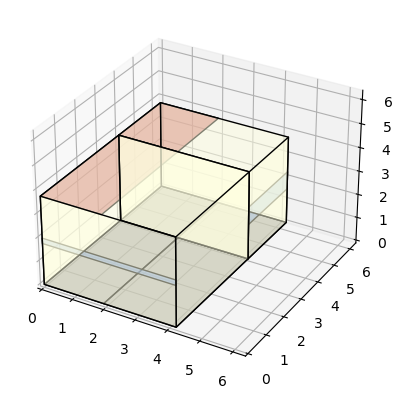

<Figure size 640x480 with 0 Axes>

INFO:archetypal:Showed the plot in 0.00 seconds


(<Figure size 640x480 with 0 Axes>, [])

In [131]:
sim = WhiteboxSimulation(schema, batch[16])
sim.summarize()
sim.shoebox.view_model()



------------------------------
EPW: c:\Users\Sam Wolk\Dropbox\mit\2023_spring\ml\ml-for-building-energy-modeling\ml-for-bem\data\epws\city_epws_indexed\cityidx_0000_USA_CA-Climate Zone 9.722880_CTZRV2.epw
Selected Template: PROG_03_VINTAGE_00_MASS_1
---ShoeboxConfig---
Height 3.7346287667293177
Width 4.206588824813849
WWR 0.06073757789789677
Facade2Foot 0.5975165522466254
Perim2Foot 0.6331432489898389
Foot2Gnd [adia %] 0.5419260330347738
Roof2Gnd [adia %] 0.5392172773770788
Orientation 0.0
---PERIM/CORE Values---
Heating Setpoint: 20.20245076558852 20.20245076558852
Cooling Setpoint: 23.458971914377386 23.458971914377386
Equipment Power Density: 8.286565544256211 8.286565544256211
Lighting Power Density: 2.8955954608345 2.8955954608345
People Density: 0.006621573123842806 0.006621573123842806
Infiltration: 0.5719361863635811 0.5719361863635811
Roof HeatCap: 148404.2417341503 148404.2417341503
Facade HeatCap: 35002.35 35002.35
U Window: 0.8014656459214534
VLT 0.5
Roof RSI: 2.662069828

In [ ]:
try:
    sim = WhiteboxSimulation(schema, batch[16])
    sim.summarize()
    res_hr, res_m = sim.simulate()
    print(res_hr.head())
    print(res_m.head())
except AssertionError as e:
    print(e)
# batch = batch_runner.storage_batch[np.argwhere(errors).flatten()]
# for i in range(batch.shape[0]):
#     if i > 0:
#         break
#     print(f'\n\n-----------{np.argwhere(errors).flatten()[i]}')
#     try:
#         sim = WhiteboxSimulation(schema, batch[i])
#         sim.summarize()
#         res_hr, res_m = sim.simulate()
#         print(res_hr.head())
#         print(res_m.head())
#     except AssertionError as e:
#         print(e)
# batch_runner.simulate(5, )

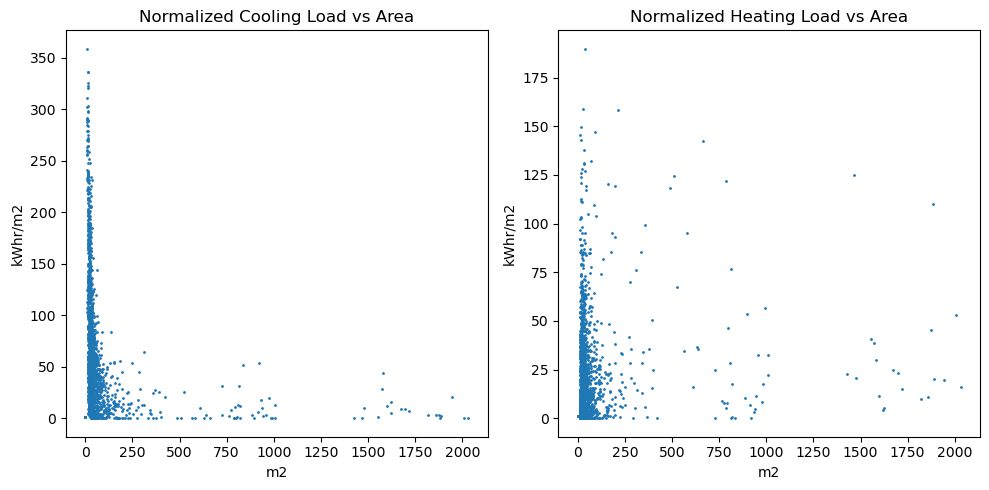

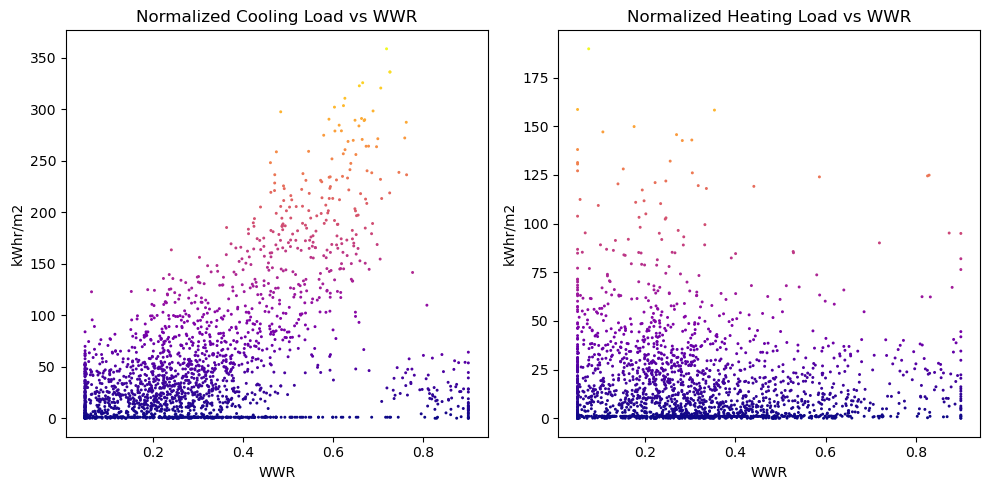

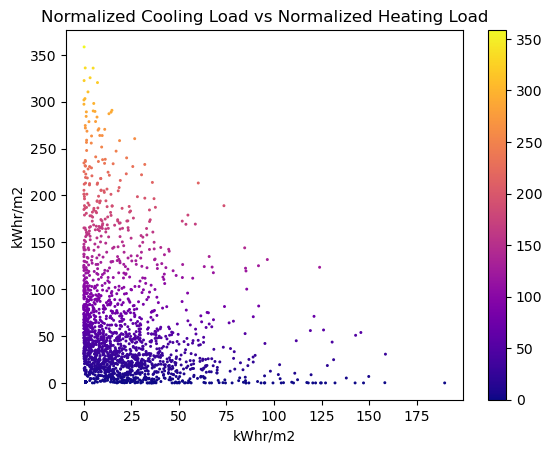

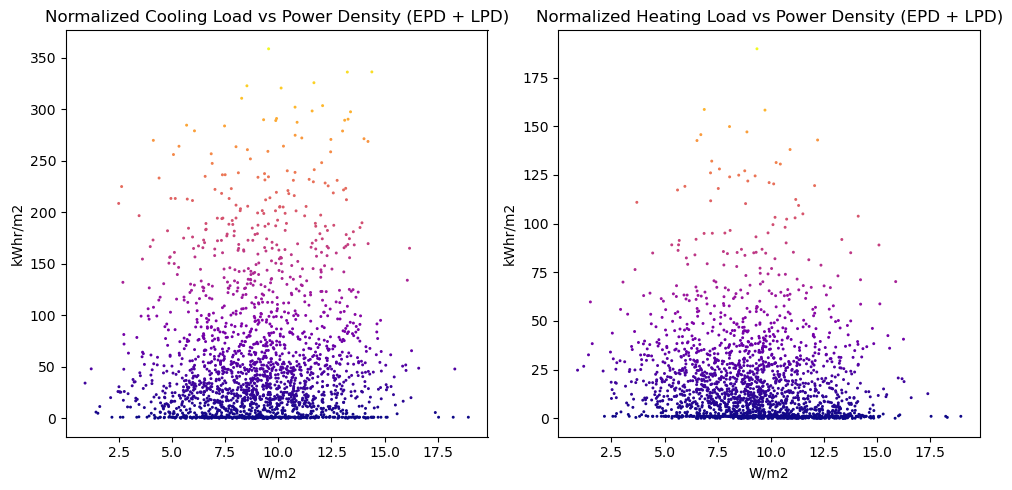

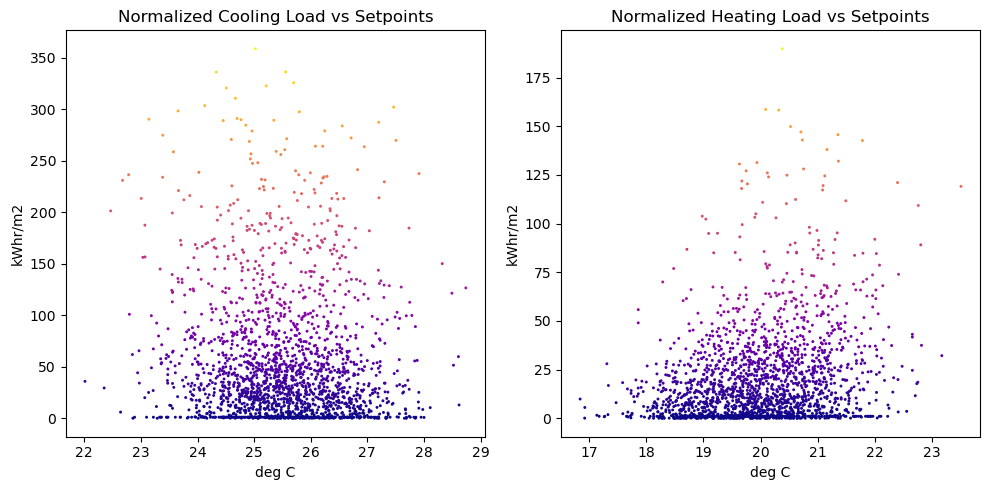

In [140]:
facade_r_values = schema["FacadeRValue"].extract_storage_values_batch(batch).flatten()
roof_r_values = schema["RoofRValue"].extract_storage_values_batch(batch).flatten()
wwrs = schema["wwr"].extract_storage_values_batch(batch).flatten()
orientations = schema["wwr"].extract_storage_values_batch(batch).flatten()
heating_setpoints = schema["HeatingSetpoint"].extract_storage_values_batch(batch).flatten()
cooling_setpoints = schema["CoolingSetpoint"].extract_storage_values_batch(batch).flatten()
epd = schema["EquipmentPowerDensity"].extract_storage_values_batch(batch).flatten()
lpd = schema["LightingPowerDensity"].extract_storage_values_batch(batch).flatten()
ppd = epd+lpd
setpoint_range = cooling_setpoints-heating_setpoints
setpoint_mid = (heating_setpoints+cooling_setpoints)/2

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].scatter(area, (total_cooling/area), s=1)
axs[0].set_title("Normalized Cooling Load vs Area")
axs[0].set_ylabel("kWhr/m2")
axs[0].set_xlabel("m2")
axs[1].scatter(area, (total_heating/area), s=1)
axs[1].set_title("Normalized Heating Load vs Area")
axs[1].set_ylabel("kWhr/m2")
axs[1].set_xlabel("m2")
fig.tight_layout()

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_title("Normalized Cooling Load vs WWR")
axs[0].scatter(wwrs,total_cooling/area,c=total_cooling/area, s=1.25, cmap="plasma")
axs[0].set_xlabel("WWR")
axs[0].set_ylabel("kWhr/m2")
axs[1].set_title("Normalized Heating Load vs WWR")
axs[1].scatter(wwrs,total_heating/area,c=total_heating/area, s=1.25, cmap="plasma")
axs[1].set_xlabel("WWR")
axs[1].set_ylabel("kWhr/m2")
fig.tight_layout()

plt.figure()
plt.title("Normalized Cooling Load vs Normalized Heating Load")
plt.scatter(total_heating/area,total_cooling/area,c=total_cooling/area, s=1.25, cmap="plasma")
plt.xlabel("kWhr/m2")
plt.ylabel("kWhr/m2")
plt.colorbar()
plt.show()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].scatter(ppd,total_cooling/area,c=total_cooling/area, s=1.25, cmap="plasma")
axs[0].set_title("Normalized Cooling Load vs Power Density (EPD + LPD)")
axs[0].set_xlabel("W/m2")
axs[0].set_ylabel("kWhr/m2")
axs[1].scatter(ppd,total_heating/area,c=total_heating/area, s=1.25, cmap="plasma")
axs[1].set_title("Normalized Heating Load vs Power Density (EPD + LPD)")
axs[1].set_xlabel("W/m2")
axs[1].set_ylabel("kWhr/m2")
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].set_title("Normalized Cooling Load vs Setpoints")
axs[0].scatter(cooling_setpoints,total_cooling/area, c=(total_cooling/area), s=1.25, cmap="plasma")
axs[0].set_xlabel("deg C")
axs[0].set_ylabel("kWhr/m2")
axs[1].set_title("Normalized Heating Load vs Setpoints")
axs[1].scatter(heating_setpoints,total_heating/area, c=(total_heating/area), s=1.25, cmap="plasma")
axs[1].set_xlabel("deg C")
axs[1].set_ylabel("kWhr/m2")
fig.tight_layout()
plt.show()

INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:Geometries rotated by 180.0 degrees around building centroid




------------------------------
EPW: c:\Users\Sam Wolk\Dropbox\mit\2023_spring\ml\ml-for-building-energy-modeling\ml-for-bem\data\epws\city_epws_indexed\cityidx_0002_USA_FL-Southwest Florida I.722108_TMY3.epw
Selected Template: PROG_03_VINTAGE_00_MASS_1
---ShoeboxConfig---
Height 2.8807165561329944
Width 3.306739058981054
WWR 0.34534503122566407
Facade2Foot 0.8735021871577295
Perim2Foot 0.5385348013093041
Foot2Gnd [adia %] 0.5935484347106219
Roof2Gnd [adia %] 0.6489386698004027
Orientation 2.0
---PERIM/CORE Values---
Heating Setpoint: 22.069723806404934 22.069723806404934
Cooling Setpoint: 24.069723806404934 24.069723806404934
Equipment Power Density: 9.037498846603281 9.037498846603281
Lighting Power Density: 2.678262108408566 2.678262108408566
People Density: 0.06172000749578246 0.06172000749578246
Infiltration: 2.945333455798086 2.945333455798086
Roof HeatCap: 263847.6709013409 263847.6709013409
Facade HeatCap: 74394.14356838928 74394.14356838928
U Window: 197.33144227527922
VLT 0.

C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 1.00it [00:00, 26.3it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 2.00it [00:00, 18.0it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 3.00it [00:00, 26.6it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.078
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 4.00it [00:00, 26.6it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:ExpandObjects completed in 0.11 seconds
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-2e1b1af1-f2e7-11ed-b10c-841b7

ExpandObjects Started.
 Begin reading Energy+.idd file.
 Done reading Energy+.idd file.
ExpandObjects Finished. Time:     0.078
ExpandObjects completed in 0.11 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 1it [00:00, 51.06it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.05.14 23:10


Simulation started
EnergyPlus Starting
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.05.14 23:10


C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 2it [00:00, 10.10it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 3it [00:00, 15.08it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 4it [00:00, 15.08it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 5it [00:00, 15.08it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 6it [00:00, 15.08it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 7it [00:00, 15.08it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b

Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 17it [00:00, 53.55it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 18it [00:00, 41.90it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 19it [00:00, 41.90it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 20it [00:00, 41.90it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 21it [00:00, 41.90it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017

Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2017


C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 22it [00:00, 32.66it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 23it [00:00, 32.66it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 24it [00:00, 32.66it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 25it [00:00, 32.66it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 26it [00:00, 29.11it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1


Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 27it [00:00, 29.11it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 28it [00:00, 29.11it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 29it [00:00, 29.11it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 30it [00:00, 27.28it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 31it [00:01, 27.28it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017

Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 33it [00:01, 27.28it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 34it [00:01, 26.27it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 35it [00:01, 26.27it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 36it [00:01, 26.27it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 37it [00:01, 26.27it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017

Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 39it [00:01, 25.95it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 40it [00:01, 25.95it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 41it [00:01, 25.95it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 42it [00:01, 25.79it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 43it [00:01, 25.79it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017

Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 10/28/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 45it [00:01, 25.79it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 46it [00:01, 25.45it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 47it [00:01, 25.45it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 48it [00:01, 25.45it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Continuing Simulation at 12/07/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 49it [00:01, 25.45it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017

Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 51it [00:01, 25.44it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 52it [00:01, 25.44it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 53it [00:01, 25.44it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 54it [00:01, 25.44it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:EnergyPlus Run Time=00hr 00min  1.79sec
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf: 55it [00:01, 25.44it/s]INFO:2e1b1af1-f2e7-11ed-b10c-841b77d62e9a.idf:EnergyPlus Completed in 1.84 seconds
C:\EnergyPlusV9-2-0\energyplus.exe 2e1b1af1-f2e7-11ed-b1

Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  1.79sec
EnergyPlus Completed in 1.84 seconds


INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']


((432.6264062561612, 2342.3324375147577), (39.65411606380946, 214.69591544589895))
432.6264
2342.3325


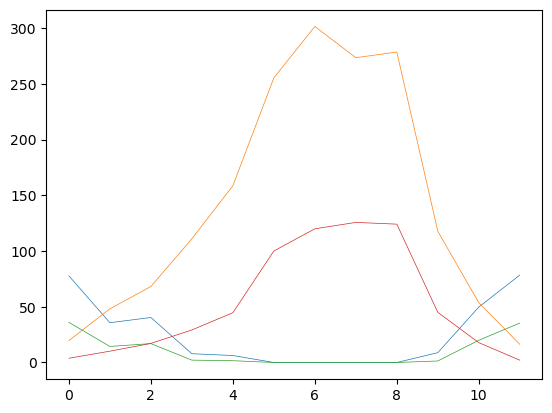

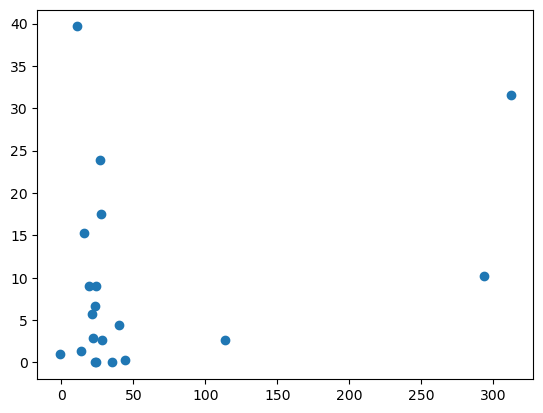

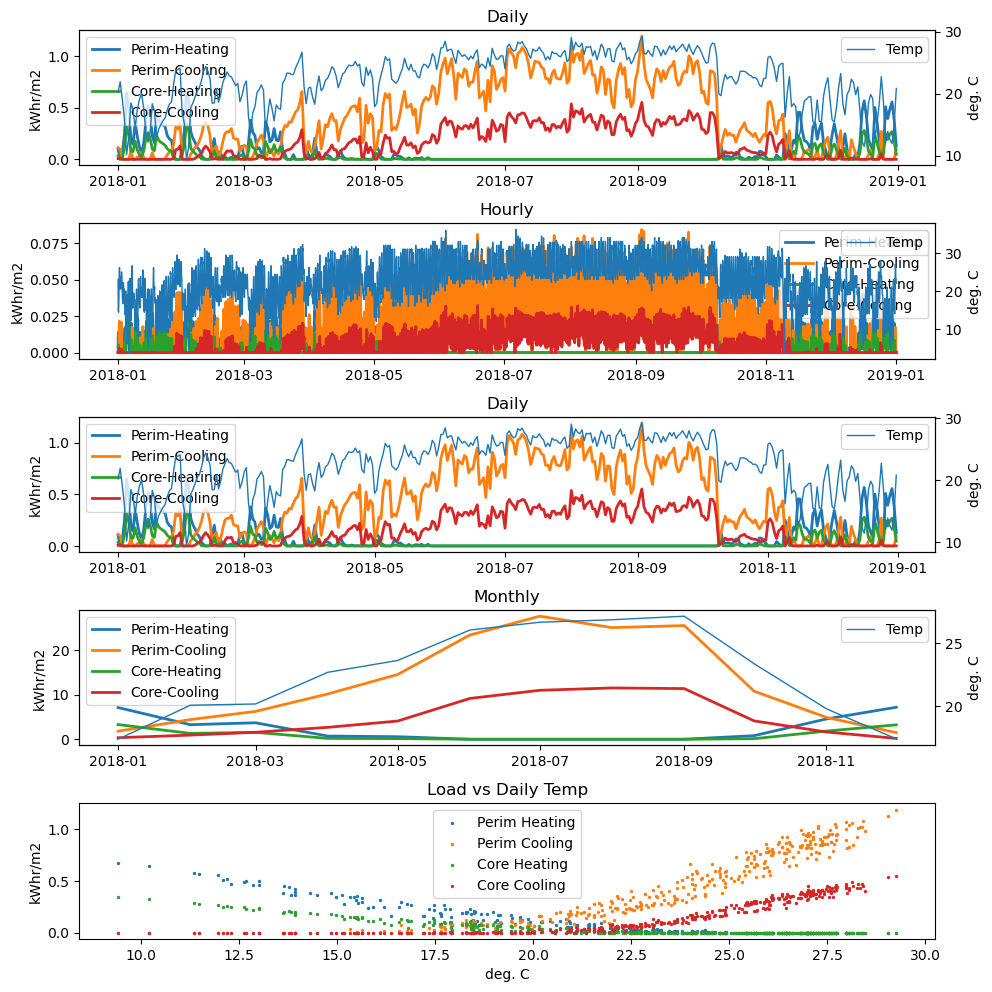

In [73]:
ix = 12 #11
fig = plt.figure()
plt.plot(monthly[ix,0,:]*2.777e-7, linewidth=0.5)
plt.plot(monthly[ix,1,:]*2.777e-7, linewidth=0.5)
plt.plot(monthly[ix,2,:]*2.777e-7, linewidth=0.5)
plt.plot(monthly[ix,3,:]*2.777e-7, linewidth=0.5)

fig = plt.figure()
plt.scatter(area, (total_heating/area))

vec = storage_batch[ix]
# schema.update_storage_vector(vec,"Infiltration",1.0)
# schema.update_storage_vector(vec,"facade_2_footprint",0.3)
sim = WhiteboxSimulation(schema, vec)
sim.summarize()
sim.simulate()
sim.plot_results(normalize=True)
print(sim.totals)
print(total_heating[ix])
print(total_cooling[ix])

0.Perimeter.Loads.OccupancySchedule: mean daily min:0.25 mean:0.67 max:0.97 quantity 0.03446461235863417

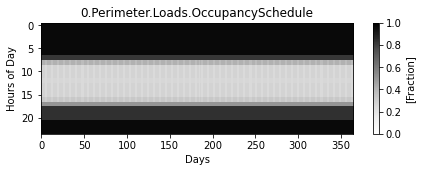